In [128]:
import torch
import torch.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [129]:
#first commit
# num matrices * batchsize * num inputs
X = torch.rand(5, 2, 3)
X

tensor([[[0.9899, 0.4017, 0.8318],
         [0.0482, 0.0056, 0.9668]],

        [[0.0945, 0.8034, 0.3343],
         [0.1810, 0.2121, 0.3605]],

        [[0.6934, 0.0845, 0.6355],
         [0.3300, 0.7633, 0.3864]],

        [[0.0821, 0.9179, 0.1841],
         [0.3608, 0.3941, 0.7248]],

        [[0.1296, 0.3793, 0.5375],
         [0.3383, 0.2579, 0.6871]]])

In [130]:
# Import the data
N = 50

data = torch.zeros(N)

for i in range(N):
    data[i] = torch.rand(1) * (-1)**i

In [147]:
# Create the Deep Learning Model
def createTheNet(printtoggle, input_size, num_hidden, num_layers, bias, batchsize):
    class lstmClassNet(nn.Module):
        def __init__(self, input_size, num_hidden, num_layers, bias, batchsize):
            
            super().__init__()
            self.printT = printtoggle
            
            # Store Parameters
            self.input_size = input_size
            self.num_hidden = num_hidden
            self.num_layers = num_layers
            self.bias = bias
            self.batchsize = batchsize
            
            # # # ----- RNN layers ------ # # #
            # nn.RNN(input_size, num_hidden)
            self.lstm = nn.LSTM(input_size, num_hidden,  num_layers,
                              bias=self.bias)
            
            # # # ----- linear layer ------ # # #
            self.out = nn.Linear(num_hidden, 1)
            
        def forward(self,x):
            
            # removed init of hidden for rnn
            # hidden = torch.zeros(self.num_layers, self.batchsize, self.num_hidden)
            if self.printT: print(f'Input: {list(x.shape)}')
            
            # run through the RNN layer
            # y,hidden = self.rnn(x, hidden)
            y,hidden = self.lstm(x)
            if self.printT: print(f'RNN-out: {list(y.shape)}')
            if self.printT: print(f'RNN-Hidden: {list(hidden[0].shape)}')
            if self.printT: print(f'RNN-Cell: {list(hidden[1].shape)}')
            
            # pass the rnn output through linear layer
            o = self.out(y)
            if self.printT: print(f'Output: {list(o.shape)}')
            
            return o, hidden
    
    modelInstance = lstmClassNet(input_size, num_hidden, num_layers, bias, batchsize)

    lossfun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.001)
    
    return modelInstance, lossfun, optimizer

In [148]:
# network parameters
input_size = 1  # channels/features of data
num_hidden = 16 # breadth of model (number of hidden layers)
num_layers = 2  # depth of model   (number of stacks of hidden layers)
seqlength  = 5  # num of data points used for learning in each segment 
batchsize  = 1  # number of batches of seqlength
bias = True
#N = 50          # number of data units

In [149]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True, input_size, num_hidden, num_layers, bias, batchsize)
print(net2)

#check all learnable parameters
for p in net2.named_parameters():
    print(f'{p[0]:>20} has size {list(p[1].shape)}')

lstmClassNet(
  (lstm): LSTM(1, 16, num_layers=2)
  (out): Linear(in_features=16, out_features=1, bias=True)
)
   lstm.weight_ih_l0 has size [64, 1]
   lstm.weight_hh_l0 has size [64, 16]
     lstm.bias_ih_l0 has size [64]
     lstm.bias_hh_l0 has size [64]
   lstm.weight_ih_l1 has size [64, 16]
   lstm.weight_hh_l1 has size [64, 16]
     lstm.bias_ih_l1 has size [64]
     lstm.bias_hh_l1 has size [64]
          out.weight has size [1, 16]
            out.bias has size [1]


In [150]:
# test the model with some data
# convert 1d array into tensor
# X = data[:seqlength].view(seqlength, 1, 1)

num_outputs = 1
# rnn & lstm: create some data
X = torch.rand(seqlength, batchsize, input_size)
y = torch.rand(seqlength, batchsize, num_outputs)

# lstm only: create initial hidden states (initialized as zeros)
# H = torch.zeros(num_layers, batchsize, num_hidden)
# C = torch.zeros(num_layers, batchsize, num_hidden)

# lstm only: the input is acutally a tuple of (hidden, cell)
# hiddenInputs = ((H,C))

# lstm only: run some data through the model & show the output sizes
# yHat,h = self.lstm(X, hiddenInputs)
#h[0] -> hidden
#h[1] -> cell

# rnn & lstm
yHat,h = net2(X)

# try a loss function
lossfun = nn.MSELoss()
lossfun(yHat, y)


Input: [5, 1, 1]
RNN-out: [5, 1, 16]
RNN-Hidden: [2, 1, 16]
RNN-Cell: [2, 1, 16]
Output: [5, 1, 1]


tensor(0.2670, grad_fn=<MseLossBackward0>)

In [151]:
# checl the learned parameters & their sizes
for p in net2.named_parameters():
    if 'weight' in p[0]:
        print(f'{p[0]} has size {list(p[1].shape)}')
        # size of weight matrix = w_li + w_if + w_ig + w_io = 4*hidden-size*Input-size

lstm.weight_ih_l0 has size [64, 1]
lstm.weight_hh_l0 has size [64, 16]
lstm.weight_ih_l1 has size [64, 16]
lstm.weight_hh_l1 has size [64, 16]
out.weight has size [1, 16]


In [152]:
# Train the Model

def trainTheModel(trainedModel, lossfun, optimizer, epochs=30):
    
    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
        
    #initialize losses & accuracy
    trainLoss   = torch.zeros(numepochs)
    trainAcc    = torch.zeros(numepochs)
    testLoss    = torch.zeros(numepochs)
    testAcc     = torch.zeros(numepochs)

    for epochi in range(numepochs):
        
        #batch loss & accuracy
        trainSegLoss = []
        trainSegAcc  = []
        hidden_state = torch.zeros(num_layers, batchsize, num_hidden) # reset the hidden state
        
        #loop over data segments / sequences
        for timei in range(N-seqlength):
            
            # Grab a snippet of data
            X = data[timei:timei+seqlength].view(seqlength, batchsize, input_size)
            y = (data[timei+seqlength] > 0).float().view(batchsize, 1)
            
            # push data to GPU
            # X = X.to(device)
            # y = y.to(device)
            
            #Forward pass & loss
            yHat,_ = trainedModel(X)
            finalValue = yHat[-1]
            loss = lossfun(finalValue, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            trainSegLoss.append(loss.item())
            
            #accuracy from this batch -> for BCE sigmoid
            # trainTrueSign = np.sign(torch.squeeze(y).numpy()) ##
            # trainPredSign = np.sign(torch.squeeze(finalValue).detach().numpy())##
            # trainSegAcc.append( 100*(trainTrueSign == trainPredSign) )
            trainTrueSign = torch.sigmoid(finalValue) > 0.5 ##
            trainPredSign = y > 0 ##
            trainSegAcc.append( 100*(trainTrueSign == trainPredSign).float().mean().item() )
        
        #average accuracy across mini-batches
        # trainAcc[epochi]  = np.mean(trainSegAcc)
        trainAcc[epochi]  = torch.tensor(trainSegAcc).float().mean()
        
        #average losses across all mini-batches
        # trainLoss[epochi] = np.mean(trainSegLoss)
        trainLoss[epochi] = torch.tensor(trainSegLoss).float().mean()
        
    return trainAcc, trainLoss, trainedModel

In [153]:
# Test the training code that it has NO ERRORS
epochs=1
myModelInstance2, lossfun2, optimizer2 = createTheNet(False, input_size, num_hidden, num_layers, bias, batchsize)
trainAcc2, trainLoss2, trainedModel2 = trainTheModel(myModelInstance2, lossfun2, optimizer2, epochs)

In [154]:
# Train the Model
myModelInstance, lossfun, optimizer = createTheNet(False, input_size, num_hidden, num_layers, bias, batchsize)
trainAcc, trainLoss, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)


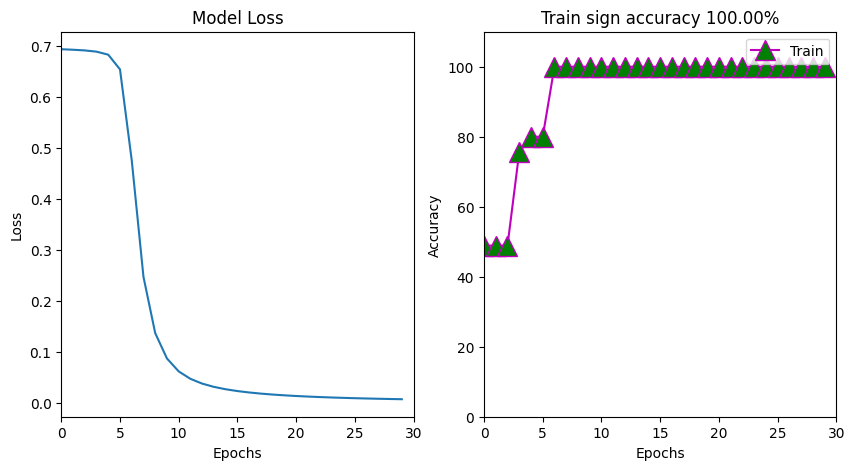

In [155]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss, label='Train')
# ax[0].plot(testLoss, label='Dev')
# ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlim([0,30])

ax[1].plot(trainAcc, 'm^-', markerfacecolor='g', markersize=15, label='Train')
# ax[1].plot(testAcc, label='Test')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Train sign accuracy {trainAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])
ax[1].set_xlim([0,30])

plt.show()

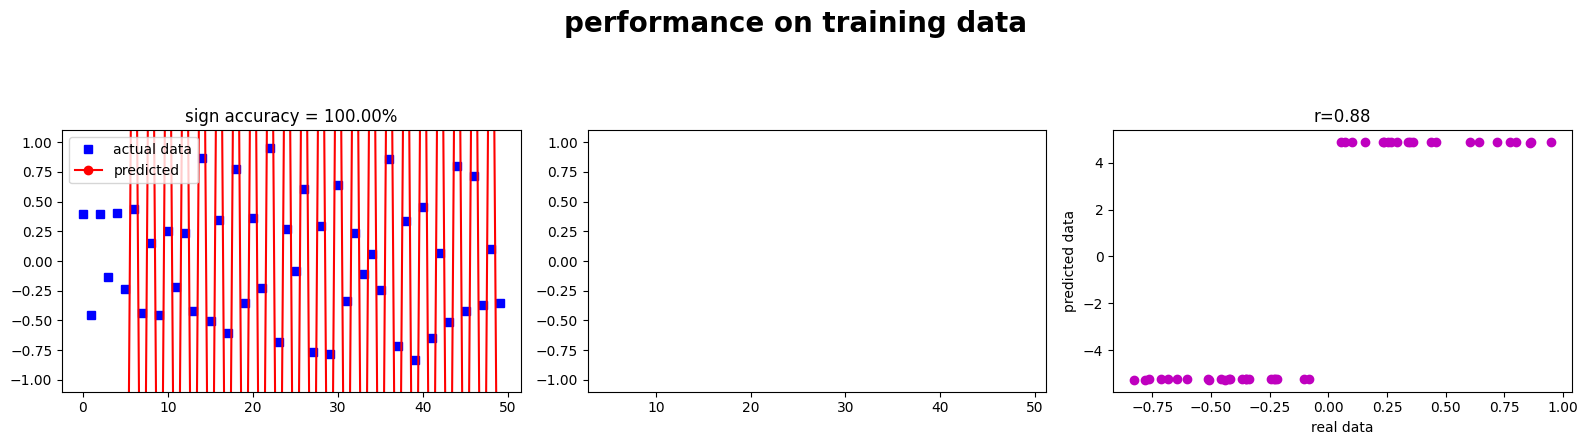

In [164]:
# Initialize hidden state
h0 = np.zeros((N, num_hidden))
h1 = np.zeros((N, num_hidden))

# Initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan

# Loop over time segments
for timei in range(N-seqlength):
    
    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength, batchsize, input_size)
    
    #forward pass & loss
    yy, hh = trainedModel(X)
    yHat[timei+seqlength] = yy[-1].item()
    # h0[timei+seqlength,:]  = hh[0][-1].detach().numpy().squeeze()
    # h1[timei+seqlength,:]  = hh[1][-1].detach().numpy().squeeze()
    
#compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])

#plot
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs' ,label='actual data')
ax[0].plot(yHat,'ro-',label='predicted')
ax[0].legend()
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('sign accuracy = %.2f%%' %signaccuracy)

ax[1].plot(data-yHat, 'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('real data')
ax[2].set_ylabel('predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f'r={r[0,1]:0.2f}')

plt.suptitle('performance on training data', fontweight='bold', fontsize=20, y=1.1)
plt.tight_layout()
plt.show()

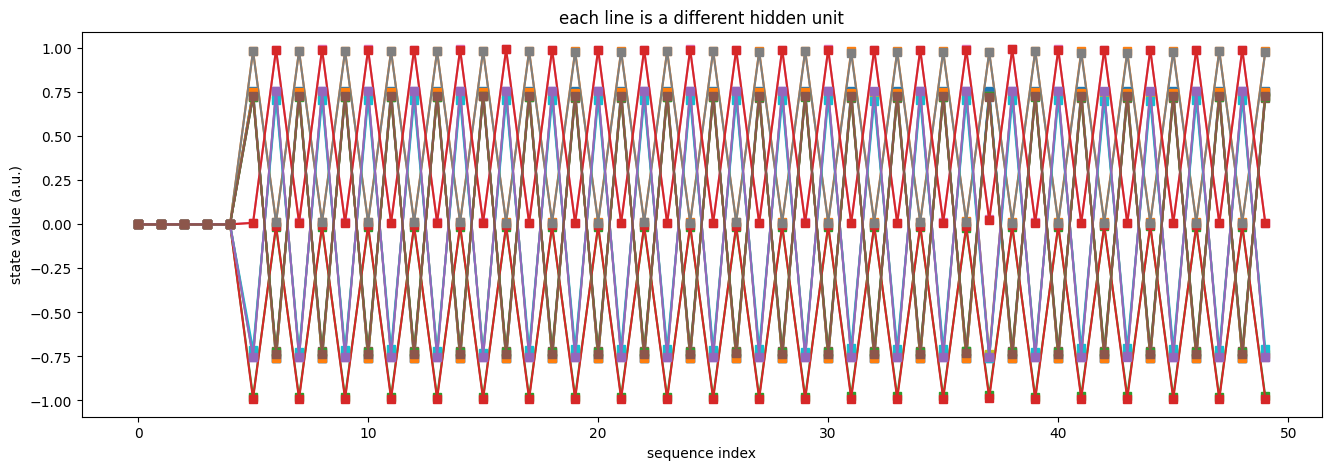

In [161]:
# show the hidden states
plt.figure(figsize=(16,5))

plt.plot(h,'s-')
plt.xlabel('sequence index')
plt.ylabel('state value (a.u.)')
plt.title('each line is a different hidden unit')
plt.show()

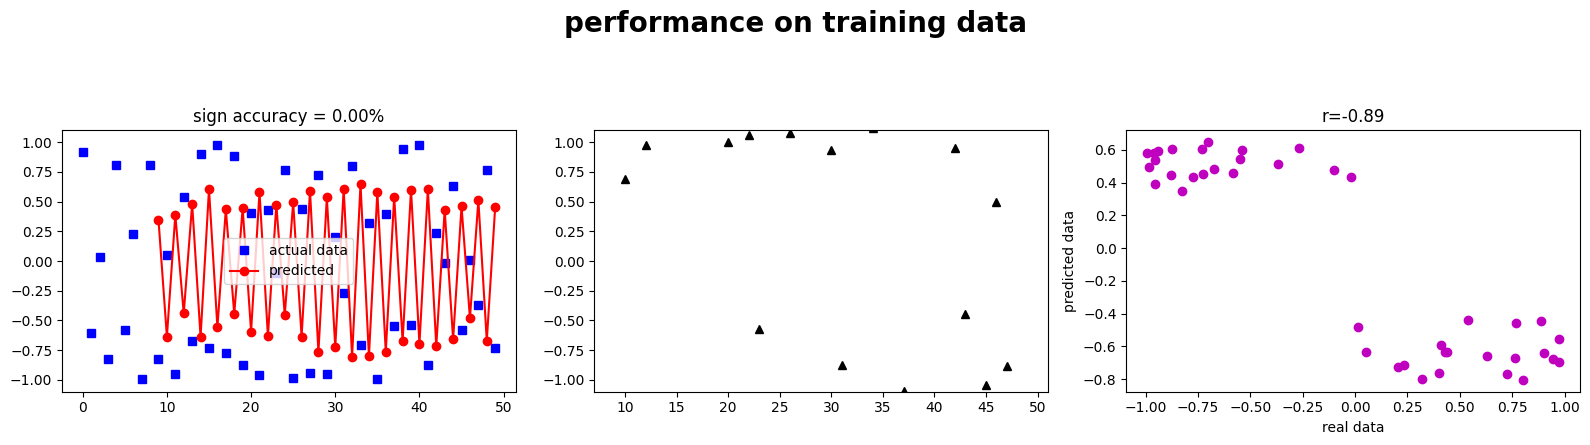

In [ ]:
# Test with new data with flipped signs

# create new data with flipped signs
newdata = torch.zeros(N)
for i in range(N):
    newdata[i] = torch.rand(1) * (-1)**(i+1)
    
    
# Initialize hidden state
h = np.zeros((N, num_hidden))

# Initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan

# Loop over time segments
for timei in range(N-seqlength):
    
    # grab a snippet of data
    X = newdata[timei:timei+seqlength].view(seqlength, batchsize, input_size)
    
    #forward pass & loss
    yy, hh = trainedModel(X)
    yHat[timei+seqlength] = yy[-1]
    h[timei+seqlength,:]  = hh.detach()
    
#compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])

#plot
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs' ,label='actual data')
ax[0].plot(yHat,'ro-',label='predicted')
ax[0].legend()
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('sign accuracy = %.2f%%' %signaccuracy)

ax[1].plot(data-yHat, 'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('real data')
ax[2].set_ylabel('predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f'r={r[0,1]:0.2f}')

plt.suptitle('performance on training data', fontweight='bold', fontsize=20, y=1.1)
plt.tight_layout()
plt.show()